In [1]:
import numpy as np
%matplotlib widget 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import sys

In [2]:
sys.path

['/lustre03/project/6064945/mehdii/3dPU/3dPU/Block_edges',
 '',
 '/cvmfs/soft.computecanada.ca/custom/python/site-packages',
 '/home/mehdii',
 '/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx512/Core/python/3.11.5/lib/python311.zip',
 '/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx512/Core/python/3.11.5/lib/python3.11',
 '/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx512/Core/python/3.11.5/lib/python3.11/lib-dynload',
 '/home/mehdii/projects/def-vidalthi/mehdii/3dPU/3dPU/virtual_3dpu/lib/python3.11/site-packages']

# Implementing on the Mesh

In [3]:
import sys
sys.path.append('/home/mehdii/projects/def-vidalthi/mehdii/3dPU/3dPU/Plateau_Problem/Triangulation_Meshing/')
sys.path.append('/home/mehdii/projects/def-vidalthi/mehdii/3dPU/3dPU/Plateau_Problem/')
sys.path.append('/home/mehdii/projects/def-vidalthi/mehdii/3dPU/3dPU/')
import pickle
with open("/home/mehdii/projects/def-vidalthi/mehdii/3dPU/3dPU/Plateau_Problem/Triangulation_Meshing/tests/test_catenoid_big.pkl", "rb") as file:
    M = pickle.load(file)

In [5]:
from block_edges import *

In [36]:
from Plateau_Problem.Triangulation_Meshing.Area_minimizing import *
from typing import *



def projection(Tr,P):
    "projete le point x sur le triangle tr"
    # On projette les deux points sur le plan du triangle et on s'assure que c'est dedans
    A = Tr[0]
    B = Tr[1]
    C = Tr[2]
    #Calcul du vecteur normal
    N = np.cross(B-A,B-C)
    n = N/np.linalg.norm(N)
    d = np.dot(n,P-A)
    return P - d*n

def area_of_triangle(Tr):
    "calcule l'aire d'un triangle array"
    p1, p2, p3 = Tr[0], Tr[1], Tr[2]
    return 0.5 * np.linalg.norm(np.cross(p2 - p1, p3 - p1))

def intersection(Tr,P,Q):
    "determine l'intersection entre PQ et le plan du triangle Tr "
    A = projection(Tr,P)
    B = projection(Tr,Q)
    # on cherche l'intersectionn entre BA et PQ
    ind = 2
    if 0 in P-Q :
        ind = list(P-Q).index(0)
    a,a_p = tuple(list(B-A)[:ind]+list(B-A)[ind+1:])
    b,b_p = tuple(list(P-Q)[:ind]+list(P-Q)[ind+1:])
    c,c_p = tuple(list(P-A)[:ind]+list(P-A)[ind+1:])
    t = (a*c_p - a_p*c)/(a*b_p - a_p*b)
    lbda = (c*b_p - c_p*b)/(a*b_p - a_p*b)
    assert np.isclose(P +t*(Q-P), A+lbda*(B-A)).all() ,(P +t*(Q-P), A+lbda*(B-A))
    return P +t*(Q-P)


def is_inside(Tr,P): 
    "determine si un point P est à l'intérieur d'un triangle Tr"
    A, B, C = Tr[0], Tr[1], Tr[2]
    Tr1 = [A,B,P]
    Tr2 = [A,C,P]
    Tr3 = [B,C,P]
    Somme = area_of_triangle(Tr1) + area_of_triangle(Tr2) + area_of_triangle(Tr3)
    Total = area_of_triangle(Tr)
    # assert(Total <= Somme), "Error dans le test"
    return np.isclose(Somme ,Total)

def traverse(Tr,P,Q):
    "determine si PQ traverse Tr"
    # les points P et Q  doivent etre dans deux sens opposés de de tr
    P_proj = projection(Tr,P)
    Q_proj = projection(Tr,Q)
    n_P = (P - P_proj)
    n_Q = (Q - Q_proj)
    if np.dot(n_P,n_Q) > 0 :
        return False
    Z = intersection(Tr,P,Q)
    return is_inside(Tr,Z) 

class Block_edges():
    def __init__(self, triangles : List[Tuple[int, int, int]], mapping : List[np.ndarray] ):
        """
        The meshing contains indexes of the triangles (i,j,k)
        andf the mapping givers the coordiantes of each point mapping[i] = array([x,y,z])
        """
        self.triangles = triangles 
        self.mapping = mapping
        self.blocked_edges = [] # contains the blocked edges as pairs of (P,Q) P and Q being two points.

    def detect_edges(self,tr):   
        
        """Gives the edges in the 3D grid 
        that go through a triangle tr"""

        x_coords = [self.mapping[point][0] for point in tr]
        y_coords = [self.mapping[point][1] for point in tr]
        z_coords = [self.mapping[point][2] for point in tr]
        
        Tr = [np.array(self.mapping[pt]) for pt in tr]  
        # Calculate min and max for each dimension with integer bounds
        x_min = math.floor(min(x_coords))
        y_min = math.floor(min(y_coords))
        z_min = math.floor(min(z_coords))

        x_max = math.ceil(max(x_coords))
        y_max = math.ceil(max(y_coords))
        z_max = math.ceil(max(z_coords))   

        for x in range(x_min, x_max + 1):
            for y in range(y_min, y_max + 1):
                for z in range(z_min, z_max + 1):
                    # Add edges parallel to the x-axis
                    if x < x_max:
                        P,Q = np.array((x, y, z)), np.array((x + 1, y, z))
                        if traverse(Tr,P,Q):
                            self.blocked_edges.append((P,Q))
                    # Add edges parallel to the y-axis
                    if y < y_max:
                        P,Q = np.array((x, y, z)), np.array((x, y + 1, z))
                        
                        if traverse(Tr,P,Q):
                            self.blocked_edges.append((P,Q))
                    # Add edges parallel to the z-axis
                    if z < z_max:
                        P,Q = np.array((x, y, z)), np.array((x, y, z + 1))
                        if traverse(Tr,P,Q):
                            self.blocked_edges.append((P,Q))

    
    def block_all_the_edges(self):
        for tr in tqdm(self.triangles):
            self.detect_edges(tr)


In [6]:
# from block_edges import *
C = Block_edges(M.triangles,M.mapping)

In [7]:
C.block_all_the_edges()

  0%|          | 0/2028 [00:00<?, ?it/s]

100%|██████████| 2028/2028 [00:18<00:00, 110.63it/s]


(-18.807352460279205, 18.807352460279205)

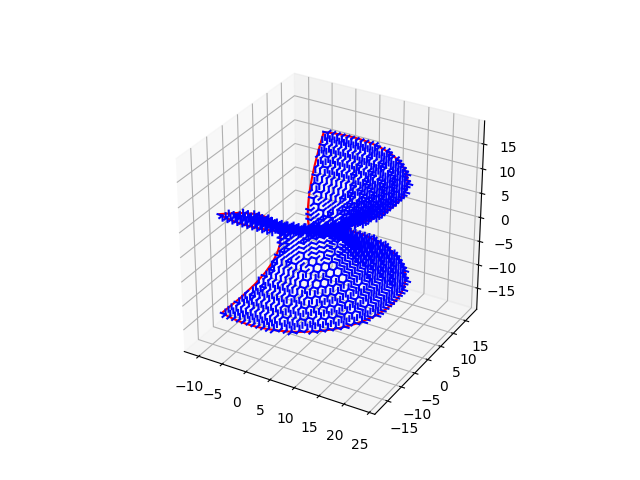

In [12]:
##Vizualize the blocked edges : 

X,Y,Z = [],[],[]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')


# #Drawing the meshing triangles
for tr in M.triangles:
    xs = [M.mapping[ind][0] for ind in tr] + [M.mapping[tr[0]][0]]
    ys = [M.mapping[ind][1] for ind in tr] + [M.mapping[tr[0]][1]]
    zs = [M.mapping[ind][2] for ind in tr] + [M.mapping[tr[0]][2]]
    # ax.plot(xs,ys,zs,color ="green")

    X = X + list(xs)
    Y = Y + list(ys)
    Z = Z + list(zs)


#Drawing the boundary
X_b,Y_b,Z_b = [],[],[]
for pt in M.boundary.points:
    X_b.append(pt[0])
    Y_b.append(pt[1])
    Z_b.append(pt[2])

plt.plot(X_b,Y_b,Z_b,color = 'red')

#Drawing the blocked edges
X_e,Y_e,Z_e = [],[],[]
for (P,Q) in C.blocked_edges:
    plt.plot([P[0],Q[0]],[P[1],Q[1]],[P[2],Q[2]],color = "b")





X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5

ax.grid(True)

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)
